In [2]:
!pip install celluloid

MovieWriter imagemagick unavailable; using Pillow instead.


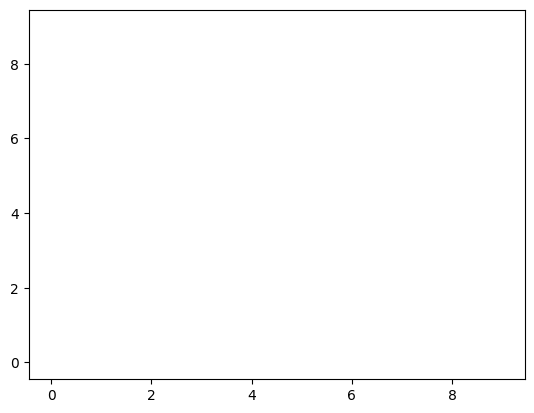

In [3]:
from matplotlib import pyplot as plt
from celluloid import Camera
 
fig = plt.figure()
camera = Camera(fig)
 
for i in range(10):
    plt.plot([i] * 10)
    camera.snap()
 
animation = camera.animate()
animation.save('celluloid_minimal.gif', writer = 'imagemagick')

In [1]:
%load_ext autoreload
%autoreload 2

warrior:  (0, 1.5)
knight:  (0, 1.5)
warrior:  (0, 2.5)
knight:  (0, 2.5)
warrior:  (0, 3.5)
archer:  (0, 3.5)
warrior:  (8, 1.5)
knight:  (8, 1.5)
warrior:  (8, 2.5)
knight:  (8, 2.5)
warrior:  (8, 3.5)
archer:  (8, 3.5)
snap!
i:  0
{'type_pt': tensor(0), 'type': 'move', 'params': {'pos_pt': tensor([0., 1.], grad_fn=<AsStridedBackward0>), 'pos': (0.0, 1.0)}}
acc_sum=0
new_pos=(0.0, 1.0)
finding path...
(1, 2.0) 2.6457513110645907
(1, 1.0) 1.7320508075688774
1.0 [(0, 1.5)]
(2, 1.5) 3.6055512754639896
(1, 2.0) 2.6457513110645907
1.0 [(0, 1.5)]
(2, 2.5) 4.58257569495584
(1, 3.0) 4.358898943540674
(2, 1.5) 3.6055512754639896
1.0 [(0, 1.5)]
(3, 2.0) 5.5677643628300215
(3, 1.0) 5.196152422706632
(2, 2.5) 4.58257569495584
1.0 [(0, 1.5)]
(3, 3.0) 6.557438524302
(2, 3.5) 6.082762530298219
(3, 2.0) 5.5677643628300215
(1, 3.0) 4.358898943540674
1.0 [(0, 1.5)]
(1, 4.0) 6.244997998398398
(2, 3.5) 6.082762530298219
1.0 [(0, 1.5)]
(3, 4.0) 7.937253933193772
(2, 4.5) 7.810249675906654
(3, 3.0) 6.5574

MovieWriter imagemagick unavailable; using Pillow instead.


i:  9
{'type_pt': tensor(1), 'type': 'attack', 'params': {'enemy_ind_pt': tensor(2), 'enemy_ind': 2, 'damage': 0.1}}
snap!


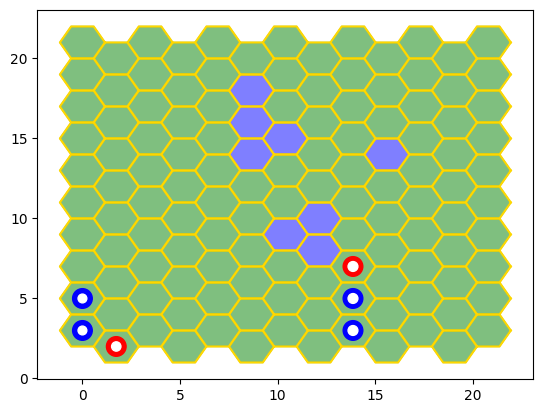

In [3]:
from Game import Game
from objects.Warriors import Archer, Knight
from graphics.MatplotlibRenderer import MatplotlibRenderer
from map.Map import Map
from Config import Config

m = Map('static/map.json')
teams = [
            [Knight(pos=(0, 1.5)), Knight(pos=(0, 2.5)), Archer(pos=(0, 3.5))], 
            [Knight(pos=(8, 1.5)), Knight(pos=(8, 2.5)), Archer(pos=(8, 3.5))], 
        ]
config = Config('static/config.json')

plt_assets = {
    'surface' : {
        'none'  : {
            'color' : 'white'
        },
        'water' : {
            'color' : 'blue'
        },
        'ground' : {
            'color' : 'brown'
        },
        'grass' : {
            'color' : 'green'
        }
    },
    'warriors': {
        'archer' : 'red',
        'knight' : 'blue'
    }
}

renderer = MatplotlibRenderer(plt_assets)
game = Game(m, teams, config, max_iter=30, record=True, renderer=renderer)
for i in range(10):
    print("i: ", i)
    game.step()
renderer.save()

In [ ]:
[w.health for team in teams for w in team]

[[<objects.Warriors.Knight at 0x1fcbe251fa0>,

In [21]:
from map.Map import serializable2map, map2serializable
import json


data = []
with open('static/map.copy.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
with open('static/map.json', 'w', encoding='utf-8') as file:
    m = serializable2map(data)
    for k, item in m['surface'].items():
        m['surface'][k]['speed'] = 0. if m['surface'][k]['s_type'] == 'water' else 1.
    m = map2serializable(m)
    json.dump(m, file)

In [3]:
game.warrior_pos

{(0, 1.5), (0.0, 4.5), (0.0, 5.5), (4.0, 1.5), (5.0, 2.0), (8, 1.5)}